# Assignment 03 - Convolutional Neural Networks I (16 Total Points)
<span style='color:red'> Due date: 01.06.2021 23:59</span>

This week's assignment is about Convolutional Neural Networks and Transfer Learning. If anything is unclear or if you find errors, feel free to post in the forum set up in Ilias or ask in the WebEx live session, or write an email to one of us.

_You can submit incomplete assignments that don't validate_. If a test cell validates correctly, you will get the points.


---

## Transfer Learning (16 points)

We used the example of pictures of an airplane hull and classifying them into pictures with cracks and without cracks during the lecture. It's time to actually implement this. Training images are hard to come by, so here, we will use images of concrete. The dataset can be found [here](https://data.mendeley.com/datasets/5y9wdsg2zt/1) and consists of 20000 images, half of which show a crack. For our purposes, we restrict the training to using 200 samples, again half of which show a crack. You can find the images in the `Data` folder where this assignment is saved.

Let's first load the dataset and take a look at what we can expect from it. The folder structure should look like this:

Project folder<br />
\--Data<br />
\----Class1<br />
\----Class2<br />

where in this case, Class1 is called "Negative" and Class2 is called "Positive". These are the folder names. An easy way to load images and directly shuffle them (why is shuffling a good idea?) is to use the `ImageDataGenerator()` class (*it's an iterator, for the Python gurus*. Of course using a library like `Pillow` or `openCV` would also work, but require more code), which will generate an object that works like the `range()` function and can save loading times for huge datasets. This is out of scope for this lecture for now.

Found 200 images belonging to 2 classes.
(200, 256, 256, 3)
(200,)


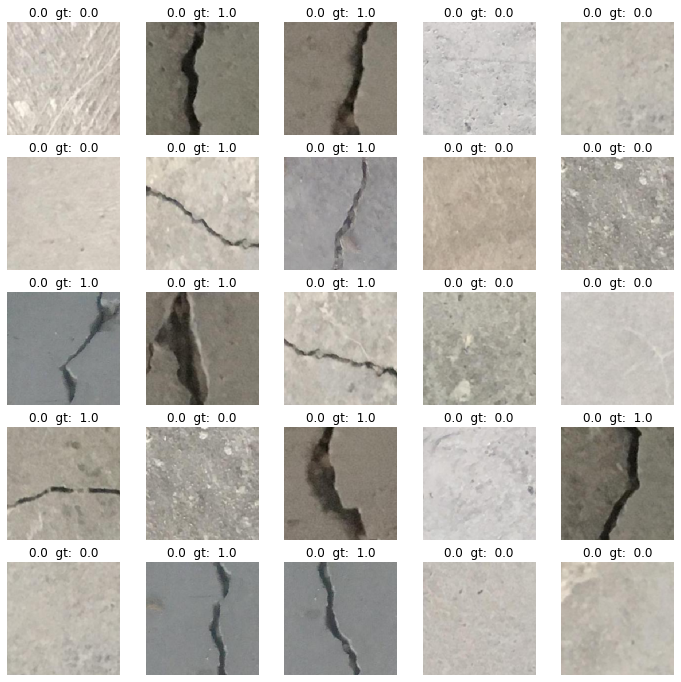

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# you can specify the class names here, but they can also be auto-detected from the folder structure
class_names = ["Positive", "Negative"]

# Instantiate an ImageDataGenerator object
# rescale transforms the pixel values from the range 0-255 to 0-1
# so we can use sigmoid activation in the end
image_generator = ImageDataGenerator(rescale=1/255)

# load the data, "Data" is the directory containing the subdirectories for each class
# "shuffle" automatically shuffles the data afterwards
train_data_gen = image_generator.flow_from_directory(directory="Data", \
                                                     shuffle=True, \
                                                     classes = class_names)

# helper function to plot many images at once
def show_ims(image_batch, label_batch, gt, r):
    plt.figure(figsize=(12,12))
    for n in range(r):
        ax = plt.subplot(int(np.sqrt(r)),int(np.sqrt(r)),n+1)
        plt.imshow(image_batch[n])
        plt.title(str(np.round(label_batch[n], 2)) + "  gt:  " + str(gt[n]))
        plt.axis('off')
        
# since train_data_gen is an iterator, we must unpack its values similar to how
# we did it in the very first lecture for the "range" iterator
# Of course this is a stupid way of doing things, since the iterator can 
# provide the samples one after the other to the CNN, but for a better
# understanding, these are given as lists. It's much more efficient to use
# the iterator itself though.
images, labels = [], []
for i in range(200):
    im, lab = next(train_data_gen)
    images.append(im[0])           # these are the X values
    labels.append(lab[0][0])       # these are the y values
    
# convert to numpy arrays to get access to some useful features
images = np.array(images)
labels = np.array(labels)
    
# plot 25 examples images
num_ims = 25
show_ims(images[:num_ims], num_ims*[0.0], labels[:num_ims], num_ims)

# print array shapes for construction of the model
print(images.shape)
print(labels.shape)

The `show_ims()` function is already defined in such a way that it can compare predictions and the ground truth later on. The left number in the title shows the predictions, which are all set to $0$ here, the right number shows the ground truth.

While quickly glancing over the test set, it didn't seem perfect. Some images were labeled incorrectly. This is an example for *uncertainty in datasets*. We will discuss these kinds of problems later.

The `ImageDataGenerator()` automatically rescaled the images to $256\times 256$. If you want to avoid this, there is an option you can set when instantiating it. For the simple demonstration now, this is fine.

Next, define the training and test datasets called `images_train`/`labels_train` and `images_test`/`labels_test` respectively. Use a *test split* of 0.8 (use 80% of the available data for training), such that 20% of the data is available for later testing (which parameter is the correct one to set here?). Instead of the manual way from last lecture, we'll use the `train_test_split` function from scikit-learn here, which makes life much easier. Check out the documentation of that function and arrange each variable correctly. The data is already shuffled, so you don't need to provide that keyword.

In [3]:
from sklearn.model_selection import train_test_split

### BEGIN SOLUTION

#test_split = int(0.8 * images.shape[0])
#
#images_train = images[:test_split]
#images_test  = images[test_split:]
#labels_train = labels[:test_split]
#labels_test  = labels[test_split:]

images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2)

### END SOLUTION

In [4]:
assert images_train.shape == (160, 256, 256, 3)
assert images_test.shape  == (40 , 256, 256, 3)
assert labels_train.shape == (160,)
assert labels_test.shape  == (40 ,)

Now we need to build our model. The idea for *transfer learning* is to take a pretrained model, strip off its last layer (the classification layer), and attach our own model. The base model is kept frozen, we will only train our own part of it with the dataset. You can check the [Keras application website](https://keras.io/api/applications/) for available models. Since most of them are really huge, we will use `NASNetMobile` here, which has a good size/accuracy ratio.

This happens in the code below. It is customary to first attach a *Pooling layer* to the base model, because most of the time the last layer in the base model is a convolution layer and we need to transform feature maps to vectors, so that we can attach standard Dense layers. The way to attach layers to a base model is to assign the base model to a variable (say, `bm`), then assign a new layer to the variable with a `(bm)` at the end of the command. Recall lesson 03-5 Examples here, the layers themselves work like functions. Complete the following code in this way:

In [5]:
# import the pretrained model
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import Model, Input


# the base model we're using here was trained with ImageNet data, which has dimension (225, 225, 3)
# so we need to convert the input layer to the size of our dataset. The way to do so is to define
# a new input layer with the apropriate shape:
new_input = Input(shape=(256,256,3))


# instantiate the pretrained model as a base model, "include_top=False" strips off the 
# last layer, so that we can attach our own, "input_tensor" defines the input shape
# this will download the weights, if you execute it for the first time
# the weights are then saved in a hidden folder, so this only happens once
# side note: this model is not a Sequential() model as we used before, but
# a Functional() model. Functional models are more flexible than sequential ones
# but adding layers works differently, as shown below.
base_model = NASNetMobile(include_top=False, input_tensor=new_input)


# set the whole base_model to untrainable
base_model.trainable = False


# disallow training for the base_model entirely
# we can fine-tune the model later
bm = base_model(new_input, training=False)
# convert the output of the last layer form the base_model to vectors 
# this is done by attaching a "GlobalAveragePooling2D()" layer
# we don't need any arguments here, but keep in mind that we need to call
# this on bm again.
# in the following line, assign the abovementioned pooling layer to bm, 
# such that "bm = $LAYER()(bm)":
### BEGIN SOLUTION
bm = GlobalAveragePooling2D()(bm)
### END SOLUTION


# the problem we are solving is a binary classification problem, so 
# we only need a single output neuron
# in the following line, create a new Dense layer (like in Assignment_02)
# with a single neuron and sigmoid activation. Assign the layer to a 
# variable called "outputs" and apply it to our base model, like you did above:
### BEGIN SOLUTION
outputs = Dense(1, activation='sigmoid')(bm)
### END SOLUTION


# define the new model
model = Model(new_input, outputs)

In [6]:
assert "Dense" in str(model.layers[-1])
assert "GlobalAveragePooling2D" in str(model.layers[-2])
assert model.layers[-1].trainable_weights[0][1].shape == (1,)
assert "shape=(1056, 1)" in str(model.layers[-1].trainable_weights[0])

You can uncomment and use the `plot_model(model)` command below to plot a graphical representation of the network, but be aware that although we loaded a "mobile" model that is quite small regarding disk space, it's still huge in architecture and will take up a lot of space below. The plotting also takes quite some time.

In [7]:
from tensorflow.keras.utils import plot_model
#plot_model(model)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
NASNet (Functional)          (None, 8, 8, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1056)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1057      
Total params: 4,270,773
Trainable params: 1,057
Non-trainable params: 4,269,716
_________________________________________________________________


Below you will find code that implements the **F1 score**, which is a good metric for binary classification problems. We did not talk about it in the lecture. You can find a good explanation of what it means on [Wikipedia](https://en.wikipedia.org/wiki/F1_score). Roughly, the F1 score is the *harmonic mean* of the precision $P$ and recall $R$ of the classification, where the *precision* is the ratio of true positives and all predicted positives, and the *recall* is the ratio of true positives and all positives in the ground truth. The F1 score is then 

\begin{equation}
  \mathrm{F}1 = 2\frac{P\cdot R}{P + R}
\end{equation}

You can use these self-defined metrics as parameters to the argument `metrics` when compiling a model. In the code below, compile the model with the optimizer `'adam'`, an appropriate choice of loss function and the metrics `'binary_accuracy'` and `f1_m` (when supplying your own function, the function name should not be in quotes).

In [8]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# compile the model below. Use the optimizer 'adam', an appropriate loss function
# and the metrics 'binary_accuracy' and f1_m
### BEGIN SOLUTION
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy', f1_m])
### END SOLUTION

Start the training of your model with `model.fit` and save the output to a variable called `history` like in Assignment_02. Use `images_train` and `labels_train`, which you defined in the beginning, train for 10 epochs, use a validation split of 0.25 and a batch_size of 16. This validation split makes sure the training/validation/test split is 60/20/20. The batch size is set to a power of 2. Effectively, taking a batch of the training data will make the backpropagation algorithm calculate the *average* of the gradient over these samples in a single batch. A large batch_size will approximate the gradient for the full dataset better, but a noisy gradient, that comes from smaller batch sizes, can help a lot in escaping local minima.

Executing the command will take around a minute to complete.

In [9]:
### BEGIN SOLUTION
history = model.fit(images_train, labels_train, epochs=10, validation_split=0.25, batch_size=16)
### END SOLUTION

Epoch 1/10
8/8 [==============================] - 27s 1s/step - loss: 0.7194 - binary_accuracy: 0.4650 - f1_m: 0.4464 - val_loss: 0.5449 - val_binary_accuracy: 0.7750 - val_f1_m: 0.7175
Epoch 2/10
8/8 [==============================] - 4s 585ms/step - loss: 0.4894 - binary_accuracy: 0.8144 - f1_m: 0.8473 - val_loss: 0.3778 - val_binary_accuracy: 0.9750 - val_f1_m: 0.9804
Epoch 3/10
8/8 [==============================] - 4s 532ms/step - loss: 0.3442 - binary_accuracy: 0.9646 - f1_m: 0.9597 - val_loss: 0.2716 - val_binary_accuracy: 1.0000 - val_f1_m: 1.0000
Epoch 4/10
8/8 [==============================] - 4s 521ms/step - loss: 0.2733 - binary_accuracy: 0.9547 - f1_m: 0.9546 - val_loss: 0.2060 - val_binary_accuracy: 1.0000 - val_f1_m: 1.0000
Epoch 5/10
8/8 [==============================] - 4s 527ms/step - loss: 0.2098 - binary_accuracy: 0.9960 - f1_m: 0.9963 - val_loss: 0.1626 - val_binary_accuracy: 1.0000 - val_f1_m: 1.0000
Epoch 6/10
8/8 [==============================] - 4s 517ms/ste

In [1]:
# moved here because of a bug in TF
# belongs to answer cell before the former one
tststrng = str(model.metrics[1].name) + " " + str(model.metrics[2].name)
assert 'adam' in str(model.optimizer)
assert 'binary_accuracy' in tststrng
assert 'f1_m' in tststrng



NameError: name 'model' is not defined

In [24]:
assert 'f1_m' in history.history.keys()
assert len(history.history["loss"]) == 10
assert history.history["val_f1_m"][-1] >= history.history["val_f1_m"][0]
assert history.history["val_f1_m"][-1] >= 0.98

Sometimes your model will perform worse than an F1 score of $F1 > 0.98$. In such a case, just restart the training. In tests the F1 score was usually better than that.

Let's see how well the predictions work. In the code below, use `y_hat_test = model.predict()` to get predictions on a subset of the test set, say 25. You can use the variable `num_ims` to slice the `images_test` array such that only 25 images are used for the prediction to save computation time.

2/2 [==============================] - 1s 201ms/step - loss: 0.0733 - binary_accuracy: 0.9750 - f1_m: 0.9865

Test loss:  0.07331692427396774
Test accuracy:  0.9750000238418579
Test F1 score:  0.9864864349365234


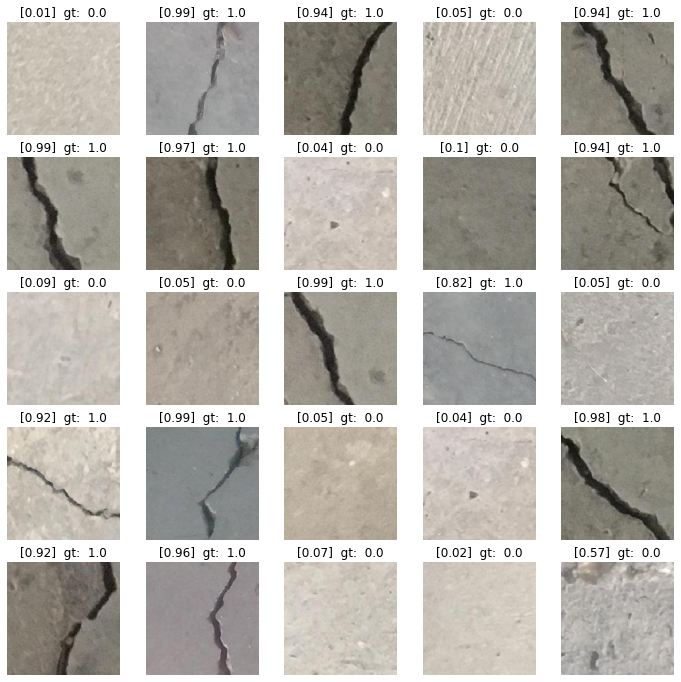

In [25]:
num_ims = 25

# save the predictions of your network for the first 25 images in your test set 
# in a variable called y_hat_test
### BEGIN SOLUTION
y_hat_test = model.predict(images_test[0:num_ims])
### END SOLUTION


# this will plot the images, the predictions and the ground truth
show_ims(images_test[0:num_ims], y_hat_test[0:num_ims], labels_test[0:num_ims], num_ims)

# to evaluate the model with all available metrics, you can use an inbuilt
# function to get a single number as an indicator of how well the model classifies
loss, bin_accuracy, f1_score = model.evaluate(images_test, labels_test)

print()
print("Test loss: ", loss)
print("Test accuracy: ", bin_accuracy)
print("Test F1 score: ", f1_score)

Note that the values calculated here are not deterministic and you might need to rerun the training a few times to get a good accuracy. In fact, the training set is so small that sometimes an F1 score of 1.0 can be reached. What does this mean?

Note that this will work a lot better when using more data. A quick test with a dataset size of 2000 got almost perfect results.

---

## Visualizing Filters and Feature Maps (0 points)
In the lecture, we talked about how filters are the weights in CNNs and how they amplify and dampen certain features in an image. It's possible to visualize their action on images. Let's use the NASNetMobile as an example again. Note that in contrast to other popular models, like VGG19, it has a very large number of layers, so unfortunately we cannot visualize everything that's going on. It will suffice to look at a few examples.

First, load the model again, but this time fully.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications.nasnet import NASNetMobile

model = NASNetMobile()

# uncomment if you'd like an overview of the whole model
# the list will be very long
#model.summary()

For us, the convolutional layers will be the interesting parts of the model. The following code iterates through all the layers in the model and saves their indices in the list `idx` for later. Only those indices belonging to convolutional layers are saved.

In [2]:
idx = []
for i,layer in enumerate(model.layers):
    if 'conv' in layer.name:
        if layer.get_weights() != []:
            filters = np.array(layer.get_weights()[0])
            # uncomment to get a huge list of all conv layers and their type and filter sizes
            print(i, layer.name, filters.shape)
            idx.append(i)

1 stem_conv1 (3, 3, 3, 32)
4 reduction_conv_1_stem_1 (1, 1, 32, 11)
10 separable_conv_1_reduction_left1_stem_1 (5, 5, 11, 1)
11 separable_conv_1_reduction_right1_stem_1 (7, 7, 32, 1)
12 separable_conv_1_bn_reduction_left1_stem_1 (11,)
13 separable_conv_1_bn_reduction_right1_stem_1 (11,)
16 separable_conv_2_reduction_left1_stem_1 (5, 5, 11, 1)
17 separable_conv_2_reduction_right1_stem_1 (7, 7, 11, 1)
19 separable_conv_2_bn_reduction_left1_stem_1 (11,)
20 separable_conv_2_bn_reduction_right1_stem_1 (11,)
24 separable_conv_1_reduction_right2_stem_1 (7, 7, 32, 1)
27 separable_conv_1_bn_reduction_right2_stem_1 (11,)
28 separable_conv_1_reduction_right3_stem_1 (5, 5, 32, 1)
29 separable_conv_1_reduction_left4_stem_1 (3, 3, 11, 1)
31 separable_conv_1_bn_reduction_right3_stem_1 (11,)
32 separable_conv_1_bn_reduction_left4_stem_1 (11,)
34 separable_conv_2_reduction_right2_stem_1 (7, 7, 11, 1)
38 separable_conv_2_bn_reduction_right2_stem_1 (11,)
39 separable_conv_2_reduction_right3_stem_1 (5, 5,

Let's look at the filters of a single conv layer first. Recall that the weights in the model are the filters. They can be accessed by using `get_weights()` on a specific layer. 

In [40]:
# unfirtunately, in NASNetMobile more advanced layers are used and layer 1 is 
# the only one using filters in a way we got to know in the lecture
filters_layer_1 = np.array(model.layers[1].get_weights()[0])
print(filters_layer_1.shape)

# this normalizes the filter values for plotting in grayscale
def normalize_filters(filters):
    f_min, f_max = filters.min(), filters.max()
    return (filters - f_min) / (f_max - f_min)

filters_layer_1 = normalize_filters(filters_layer_1)

(3, 3, 3, 32)


There are 32 filters with a receptive field of size $3\times 3$ ($\times 3$, because the input image is RGB) in the first layer. We can plot them all at once in a roughly square grid:

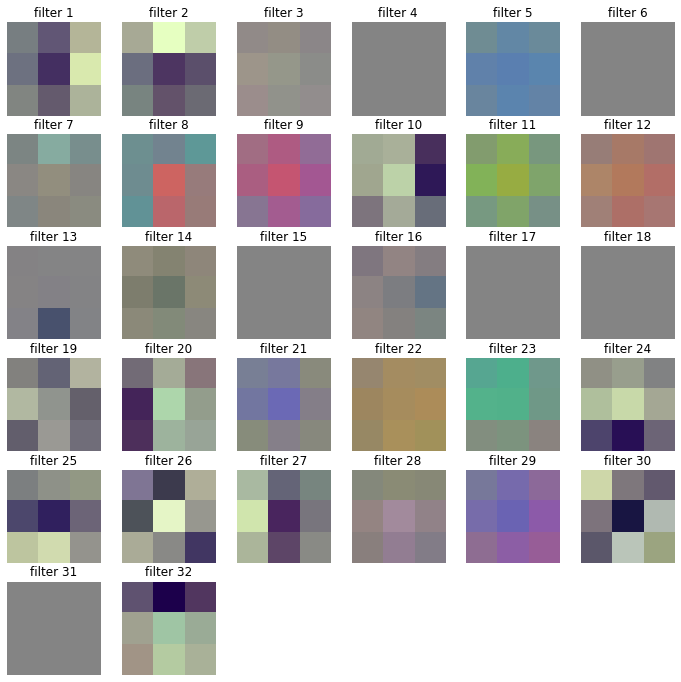

In [41]:
def plot_filters(filters, r):
    plt.figure(figsize=(12,12))
    for i in range(r):
        ax = plt.subplot(int(np.sqrt(r)+1),int(np.sqrt(r)+1),i+1)
        plt.imshow(filters[:,:,:,i], cmap='gray')
        plt.title("filter " + str(i+1))
        plt.axis('off')
        
plot_filters(filters_layer_1, filters_layer_1.shape[-1])

These filters serve different purposes. Some detect edges, some detect ends of edges, some detect diagonals and so on. To see the effect of these filters on image input, we can plot the resulting feature maps. For this, we have to create a new model, that consists of the input layer of NASNetMobile and the outputs of its first layer.

In [42]:
model_1 = keras.Model(inputs=model.inputs, outputs=model.layers[1].output)

Let's load an example from the concrete crack dataset to see what these filters do:

In [43]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# load image
crack_img = load_img('Data/Positive/00001.jpg', target_size=(224, 224))
nocrack_img = load_img('Data/Negative/00001.jpg', target_size=(224, 224))

# convert image to numpy array for easier processing
crack_img = img_to_array(crack_img)
nocrack_img = img_to_array(nocrack_img)

# the shape of a single sample is (1, ...), the following function achieves that
crack_img = np.expand_dims(crack_img, axis=0)
nocrack_img = np.expand_dims(nocrack_img, axis=0)

To get the feature maps from the first layer, we can now simply use the `predict` method of the new model:

In [44]:
# try the same with nocrack_img
fms_layer_1 = model_1.predict(crack_img)
print(fms_layer_1[0].shape)

(111, 111, 32)


As expected, there are 32 feature maps, each one corresponding to one of the filters above. The feature maps can be plotted in a similar way:

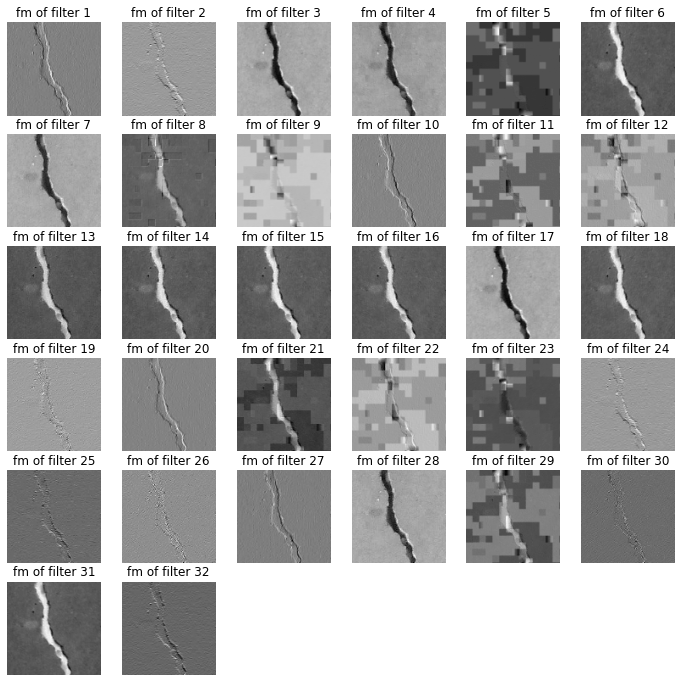

In [45]:
def show_conv_fms(filters, r):
    plt.figure(figsize=(12,12))
    for n in range(r):
        ax = plt.subplot(int(np.sqrt(r)+1),int(np.sqrt(r)+1),n+1)
        plt.imshow(filters[:,:,n], cmap='gray')
        plt.title("fm of filter " + str(n+1))
        plt.axis('off')

show_conv_fms(fms_layer_1[0], fms_layer_1[0].shape[-1])

A few different things are happening here. Some filters concentrate more on the background of the image, some concentrate on the foreground. Some filters amplify edges, some filters dampen them. Some filters invert the image, others add noise.

Let's look at what happens to an image that contains a dog, which the network should know from the ImageNet dataset:

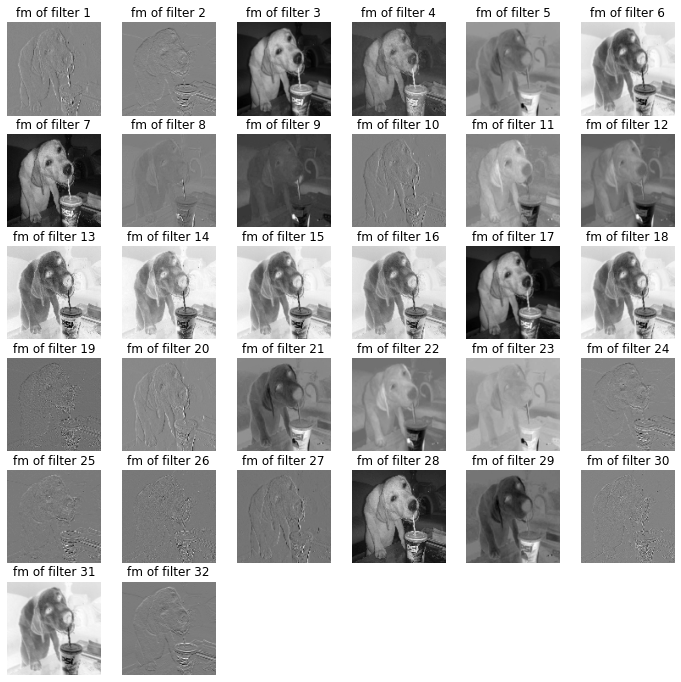

In [46]:
dog_img = load_img('pepsi_dog.jpg', target_size=(224, 224))
dog_img = img_to_array(dog_img)
dog_img = np.expand_dims(dog_img, axis=0)

fms_layer_1 = model_1.predict(dog_img)

show_conv_fms(fms_layer_1[0], fms_layer_1[0].shape[-1])

Images where a bit more is going on show the action of the filters a bit better. Again, the same things as before happen. Foreground or background amplification, edge amplification or damping, inverting images or adding noise. Sometimes the dog is visible well and the pepsi can isn't, sometimes the situation is inverted.

Filters try to extract information about the composition of the image and spatial positioning of the objects therein. This is just what happens in the first layer. The following code gets all convolutional layers, then creates a model with multiple outputs. Each output in this new model corresponds to the output of a convolutional layer from NASNetMobile.

In [47]:
outputs = [model.layers[i+1].output for i in idx]
model_full = keras.Model(inputs=model.inputs, outputs=outputs)
#model_full.summary()

`predict()` will now produce a list of _all_ feature maps in the whole model. In the case of NASNetMobile, this is a huge amount of feature maps. We can only take a look at a few of them.

In [48]:
fms = model_full.predict(dog_img)
len(fms)

356

The following code plots all feature maps up to a cutoff index:

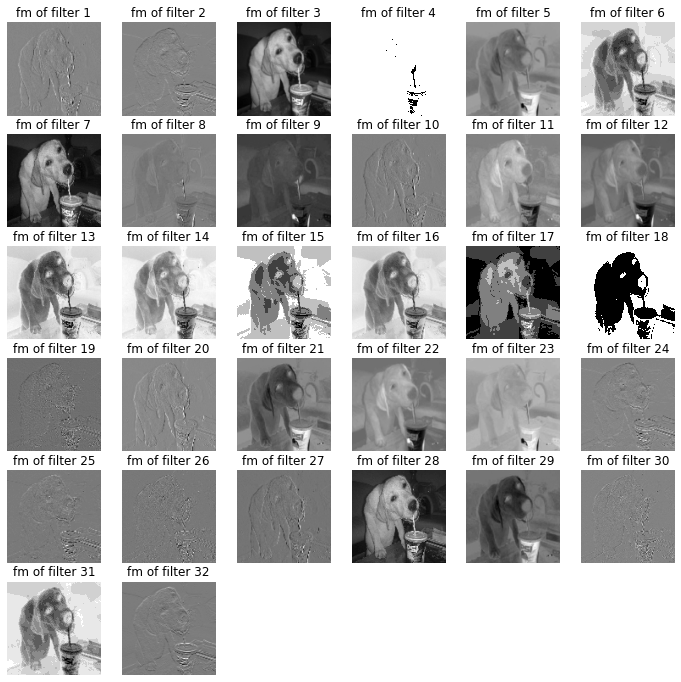

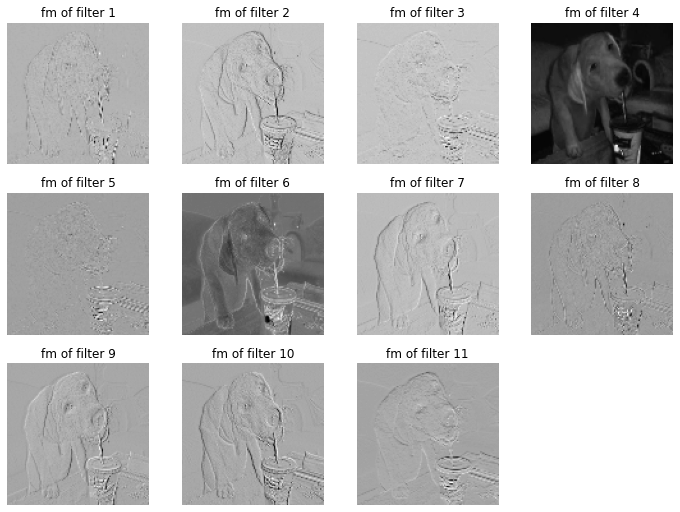

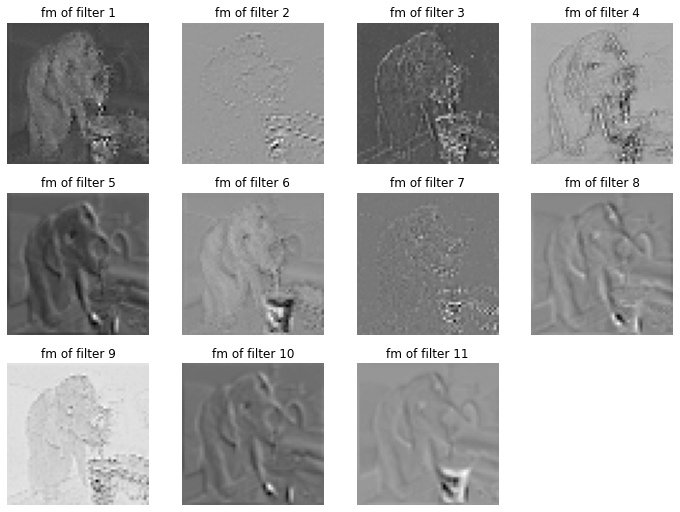

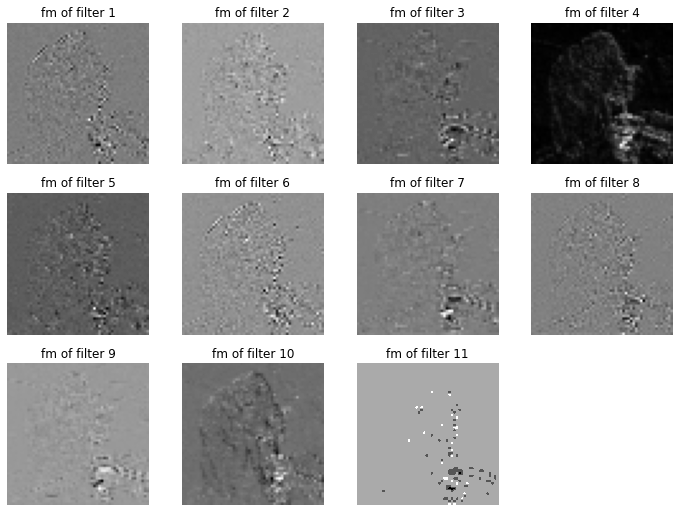

In [52]:
# try also -4:-1, and 200:205 for example
for fm in fms[0:4]:
    show_conv_fms(fm[0], fm.shape[-1])

The layers try to find a sensible embedding of the original image in a low-dimensional space. This is what the last plot of layer -1 shows. This is also what we used as input for the classification layer in the first part of this assignment.

Unfortunately, NASNetMobile is a highly advanced model and uses more sophisticated layers than those we got to know in the lecture. If you download this notebook, feel free to load VGG19 instead of NASNetMobile. It's easier to understand and has a lot more to offer visualization-wise.

---